In [1]:
# Standard or standard-ish imports
import os
import tempfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Less standard, but still pip- or conda-installable
import xarray as xr
import zarr
import netCDF4 as nc 
from azure.storage.blob import ContainerClient
from netCDF4 import Dataset

container_name = 'daymetv3-raw'
daymet_azure_storage_url = 'https://daymet.blob.core.windows.net/'

daymet_container_client = ContainerClient(account_url=daymet_azure_storage_url, 
                                         container_name=container_name,
                                         credential=None)

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(),'daymet')
os.makedirs(temp_dir,exist_ok=True)

In [2]:
def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('.', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {}'.format(os.path.basename(url)),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename

def build_url(variable, year, region):
    return f'https://daymet.blob.core.windows.net/daymetv3-raw/daymet_v3_{variable}_{year}_{region}.nc4'

def download_data(variable, years, region):
    return [
        download_url(build_url(variable, year, region))
        for year in years
    ]

In [3]:
variable = 'tmax'
years = np.arange(1980, 2000)
regions = ['na', 'hawaii', 'puertorico']

filenames = download_data(variable, years, regions[1])
ds = xr.open_mfdataset(filenames, engine='h5netcdf')

Bypassing download of already-downloaded file daymet_v3_tmax_1980_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1981_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1982_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1983_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1984_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1985_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1986_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1987_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1988_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1989_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1990_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1991_hawaii.nc4
Bypassing download of already-downloaded file daymet_v3_tmax_1992_hawaii.nc4

In [4]:
ds.coords["month"] = ds.time.dt.month
ds = ds.swap_dims({"time": "month"})
monthly_mean = ds.groupby("month").mean()

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


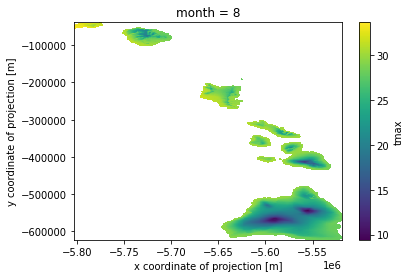

In [5]:
monthly_mean[variable][7].plot()

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


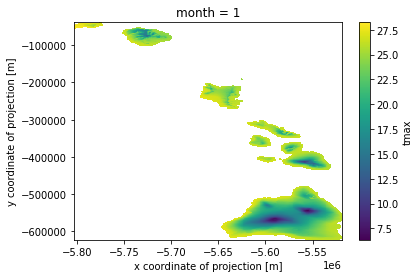

In [6]:
monthly_mean[variable][0].plot()

In [13]:
store = zarr.DirectoryStore('./store.zarr')
monthly_mean.to_zarr(store)

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
